In [1]:
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
df_game = spark.read.csv('./1. Query/Game.csv', inferSchema=True, header=True)
df_game.show()

+------+-----------------+
|GameID|         GameName|
+------+-----------------+
| GA001|       Elden Ring|
| GA002|   Genshin Impact|
| GA003|       Elden Ring|
| GA004|Honkai: Star Rail|
| GA005|           Dota 2|
| GA006|          FIFA 23|
| GA007|League of Legends|
| GA008|       Elden Ring|
| GA009|      Overwatch 2|
| GA010|Honkai: Star Rail|
| GA011|           Roblox|
| GA012|        Minecraft|
| GA013|           Roblox|
| GA014|       Elden Ring|
| GA015|             PUBG|
| GA016|         Valorant|
| GA017|           Dota 2|
| GA018|         Valorant|
| GA019|         Valorant|
| GA020|            CS:GO|
+------+-----------------+



In [4]:
df_customer = spark.read.csv('./1. Query/Customer.csv', inferSchema=True, header=True)
df_product = spark.read.csv('./1. Query/Product.csv', inferSchema=True, header=True)
df_transactionDetail = spark.read.csv('./1. Query/TransactionDetail.csv', inferSchema=True, header=True)
df_transactionHeader = spark.read.csv('./1. Query/TransactionHeader.csv', inferSchema=True, header=True)

In [5]:
df_game.registerTempTable('Game')
df_customer.registerTempTable('Customer')
df_product.registerTempTable('Product')
df_transactionDetail.registerTempTable('TransactionDetail')
df_transactionHeader.registerTempTable('TransactionHeader')

In [7]:
# 1. Show the total quantity sold per game where quantity > 1. Use bar chart to visualize the data.

query1 = spark.sql("""
    SELECT GameName, SUM(Quantity) as TotalSold
    FROM Game as g
    JOIN Product as p ON p.GameID = g.GameID
    JOIN TransactionDetail as td ON td.ProductID = p.ProductID
    WHERE Quantity > 1
    GROUP BY GameName
    ORDER BY TotalSold DESC
""")

query1.show()

+-----------------+---------+
|         GameName|TotalSold|
+-----------------+---------+
|       Elden Ring|       89|
|           Roblox|       89|
|         Valorant|       88|
|            CS:GO|       83|
|           Dota 2|       41|
|          FIFA 23|       28|
|        Minecraft|       15|
|League of Legends|       14|
|             PUBG|       12|
|Honkai: Star Rail|        9|
|      Overwatch 2|        8|
|   Genshin Impact|        4|
+-----------------+---------+



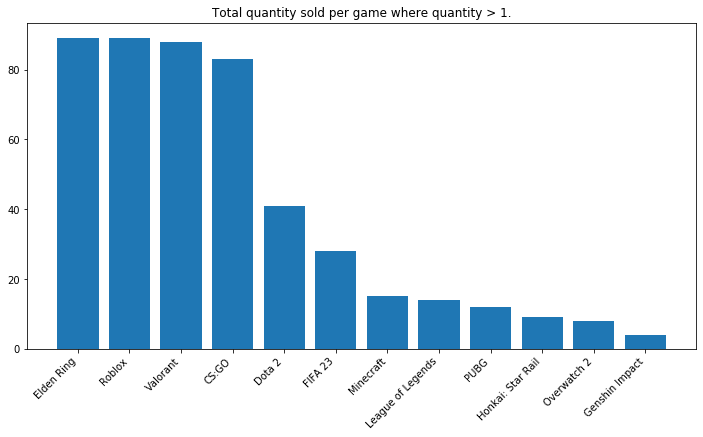

In [10]:
# Plotting nomor 1

query1Plot = query1.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(query1Plot["GameName"], query1Plot["TotalSold"])
plt.title("Total quantity sold per game where quantity > 1.")
plt.xticks(rotation=45, ha='right')
plt.show()

In [12]:
# 2. Show the total revenue per product where price > 1000 and quantity >= 2. Use pie chart to visualize the data.

query2 = spark.sql("""
    SELECT ProductName, SUM(Price * Quantity) as TotalRevenue
    FROM Product as p
    JOIN TransactionDetail as td ON td.ProductID = p.ProductID
    WHERE Price > 1000 AND Quantity >= 2
    GROUP BY ProductName
    ORDER BY TotalRevenue DESC
    LIMIT 10
""")

query2.show()

+--------------------+------------+
|         ProductName|TotalRevenue|
+--------------------+------------+
|   CS:GO - Character|      140468|
|  Roblox - Character|      114104|
|     Valorant - Skin|       84316|
|   Valorant - Weapon|       74272|
|Elden Ring - Char...|       63468|
|       Roblox - Skin|       60816|
| Valorant - XP Boost|       50570|
|Minecraft - XP Boost|       49125|
|  PUBG - Battle Pass|       48612|
|      CS:GO - Weapon|       47198|
+--------------------+------------+



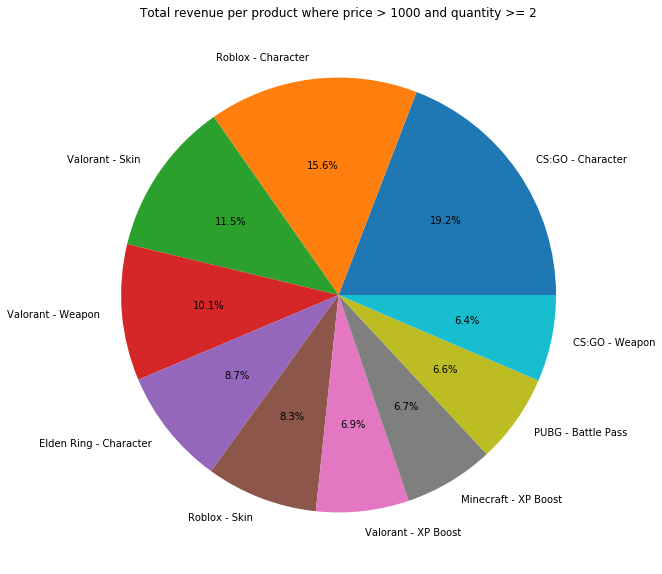

In [18]:
# Plotting nomor 2

query2Plot = query2.toPandas()

plt.figure(figsize=(10,10))
plt.pie(query2Plot["TotalRevenue"], labels=query2Plot["ProductName"], autopct='%1.1f%%')
plt.title("Total revenue per product where price > 1000 and quantity >= 2")
plt.show()

In [30]:
# 3. Show the total revenue and quantity per game where price > 500. Use line plot to visualize the data.

query3 = spark.sql("""
SELECT GameName,
       SUM(Quantity * Price) AS TotalRevenue,
       CASE 
           WHEN SUM(Quantity * Price) >= 10000 THEN 'High Revenue'
           WHEN SUM(Quantity * Price) >= 5000 THEN 'Medium Revenue'
           ELSE 'Low Revenue'
       END AS RevenueCategory
FROM Game AS g
JOIN Product AS p ON p.GameID = g.GameID
JOIN TransactionDetail AS td ON td.ProductID = p.ProductID
WHERE Price > 500
GROUP BY GameName
ORDER BY TotalRevenue

""")

query3.show()

+-----------------+------------+---------------+
|         GameName|TotalRevenue|RevenueCategory|
+-----------------+------------+---------------+
|League of Legends|       12256|   High Revenue|
|   Genshin Impact|       12745|   High Revenue|
|Honkai: Star Rail|       39124|   High Revenue|
|      Overwatch 2|       42944|   High Revenue|
|          FIFA 23|       49818|   High Revenue|
|             PUBG|       52058|   High Revenue|
|        Minecraft|       52400|   High Revenue|
|           Dota 2|      118015|   High Revenue|
|           Roblox|      280795|   High Revenue|
|       Elden Ring|      285897|   High Revenue|
|         Valorant|      293502|   High Revenue|
|            CS:GO|      333935|   High Revenue|
+-----------------+------------+---------------+



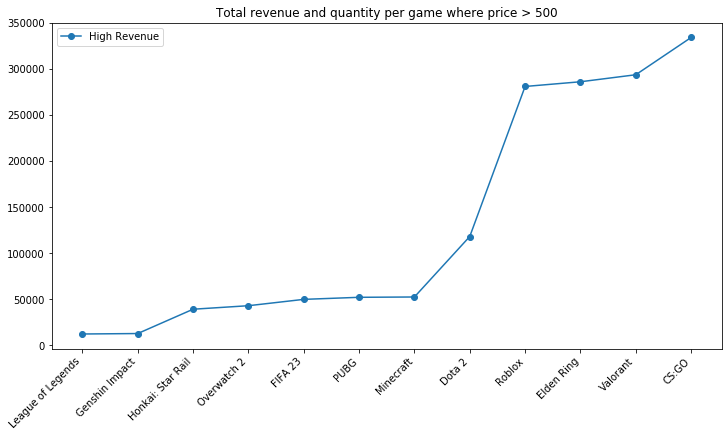

In [34]:
# Plotting Nomor 3

query3Plot = query3.toPandas()

plt.figure(figsize=(12, 6))
plt.title("Total revenue and quantity per game where price > 500")
for category in query3Plot["RevenueCategory"].unique():
    subset = query3Plot[query3Plot["RevenueCategory"] == category]
    plt.plot(query3Plot["GameName"], query3Plot["TotalRevenue"], marker='o', linestyle='-', label=category)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.show()

In [65]:
# Wajib
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import when

# Classification
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator # Kalo dibutuhkan

In [36]:
df_train = spark.read.csv('./2. Classification/train.csv', inferSchema=True, header=True)
df_test = spark.read.csv('./2. Classification/test.csv', inferSchema=True, header=True)

In [37]:
df_train = df_train.dropna()
df_test = df_test.dropna()
df_train.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [39]:
def encode(df):
    return (
        df.withColumn("Sex", 
            when(df["Sex"] == 'M', 0)
            .when(df["Sex"] == 'F', 1)
        ).withColumn("ChestPainType", 
            when(df["ChestPainType"] == 'ATA', 0)
            .when(df["ChestPainType"] == 'NAP', 1)
            .when(df["ChestPainType"] == 'ASY', 2)
            .when(df["ChestPainType"] =='TA', 3)
        ).withColumn("RestingECG", 
            when(df["RestingECG"] == 'Normal', 0)
            .when(df["RestingECG"] == 'ST', 1)
            .when(df["RestingECG"] == 'LVH', 2)
        ).withColumn("ExerciseAngina",
            when(df["ExerciseAngina"] == 'N', 0)
            .when(df["ExerciseAngina"] == 'Y', 1)
        ).withColumn("ST_Slope",
            when(df["ST_Slope"] == 'Down', 0)
            .when(df["ST_Slope"] == 'Flat', 1)
            .when(df["ST_Slope"] == 'Up', 2)
        )
    )

In [40]:
df_train = encode(df_train)
df_test = encode(df_test)

In [41]:
df_train.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  0|            0|      140|        289|        0|         0|  172|             0|    0.0|       2|           0|
| 49|  1|            1|      160|        180|        0|         0|  156|             0|    1.0|       1|           1|
| 37|  0|            0|      130|        283|        0|         1|   98|             0|    0.0|       2|           0|
| 48|  1|            2|      138|        214|        0|         0|  108|             1|    1.5|       1|           1|
| 54|  0|            1|      150|        195|        0|         0|  122|             0|    0.0|       2|           0|
| 39|  0|            1|      120|        339|        0| 

In [44]:
feature_cols = [
    "Age", "Sex", "ChestPainType", 
    "RestingBP", "Cholesterol", "FastingBS", 
    "RestingECG", "MaxHR", "ExerciseAngina",
    "Oldpeak", "ST_Slope"
]

df_train = VectorAssembler(inputCols=feature_cols, outputCol='vector').transform(df_train)
df_train = StandardScaler(inputCol='vector', outputCol='features').fit(df_train).transform(df_train)

In [45]:
df_test = VectorAssembler(inputCols=feature_cols, outputCol='vector').transform(df_test)
df_test = StandardScaler(inputCol='vector', outputCol='features').fit(df_test).transform(df_test)

In [46]:
df_train.show()
df_test.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+--------------------+--------------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|              vector|            features|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+--------------------+--------------------+
| 40|  0|            0|      140|        289|        0|         0|  172|             0|    0.0|       2|           0|(11,[0,3,4,7,10],...|(11,[0,3,4,7,10],...|
| 49|  1|            1|      160|        180|        0|         0|  156|             0|    1.0|       1|           1|[49.0,1.0,1.0,160...|[5.14433996196934...|
| 37|  0|            0|      130|        283|        0|         1|   98|             0|    0.0|       2|           0|(11,[0,3,4,6,7,10...|(11,[0,3,4,6,7,10...|
| 48|  1|            2|      138|       

In [47]:
model = LogisticRegression(featuresCol='features', labelCol='HeartDisease').fit(df_train)

In [48]:
evaluator = BinaryClassificationEvaluator(labelCol='HeartDisease')
acc = evaluator.evaluate(model.transform(df_test))
acc

0.8127812781278129

In [49]:
# Clustering

df_cluster = spark.read.csv('./3. Clustering/marketing_campaign.csv', inferSchema=True, header=True)

In [50]:
df_cluster.show()

+----+----------+----------+--------------+------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|
+----+----------+----------+--------------+------+-------+--------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+
|5524|      1957|Graduation|        Single| 58138|      0|       0|     58|     635|       88|            546|            172|              88|          88|                3|              8|                 10|                4|                7|
|2174|      

In [53]:
df_cluster = df_cluster.select(["Income", "Kidhome", "Teenhome", "Recency", 
                            "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",
                           "NumWebVisitsMonth"])

df_cluster.show()

+------+-------+--------+-------+-----------------+---------------+-------------------+-----------------+-----------------+
|Income|Kidhome|Teenhome|Recency|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|
+------+-------+--------+-------+-----------------+---------------+-------------------+-----------------+-----------------+
| 58138|      0|       0|     58|                3|              8|                 10|                4|                7|
| 46344|      1|       1|     38|                2|              1|                  1|                2|                5|
| 71613|      0|       0|     26|                1|              8|                  2|               10|                4|
| 26646|      1|       0|     26|                2|              2|                  0|                4|                6|
| 58293|      1|       0|     94|                5|              5|                  3|                6|                5|
| 62513|

In [54]:
# Ga perlu encode HARUSNYA karena udah angka semua
df_cluster = df_cluster.dropna()

df_cluster.show()

+------+-------+--------+-------+-----------------+---------------+-------------------+-----------------+-----------------+
|Income|Kidhome|Teenhome|Recency|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|
+------+-------+--------+-------+-----------------+---------------+-------------------+-----------------+-----------------+
| 58138|      0|       0|     58|                3|              8|                 10|                4|                7|
| 46344|      1|       1|     38|                2|              1|                  1|                2|                5|
| 71613|      0|       0|     26|                1|              8|                  2|               10|                4|
| 26646|      1|       0|     26|                2|              2|                  0|                4|                6|
| 58293|      1|       0|     94|                5|              5|                  3|                6|                5|
| 62513|

In [55]:
df_cluster = VectorAssembler(inputCols=df_cluster.columns, outputCol='vector').transform(df_cluster)
df_cluster = StandardScaler(inputCol='vector', outputCol='features').fit(df_cluster).transform(df_cluster)

In [56]:
kmeans = KMeans(featuresCol='features', k=3)
model = kmeans.fit(df_cluster)

In [57]:
cluster = model.transform(df_cluster)
cluster.show()

+------+-------+--------+-------+-----------------+---------------+-------------------+-----------------+-----------------+--------------------+--------------------+----------+
|Income|Kidhome|Teenhome|Recency|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|              vector|            features|prediction|
+------+-------+--------+-------+-----------------+---------------+-------------------+-----------------+-----------------+--------------------+--------------------+----------+
| 58138|      0|       0|     58|                3|              8|                 10|                4|                7|[58138.0,0.0,0.0,...|[2.70078674588437...|         1|
| 46344|      1|       1|     38|                2|              1|                  1|                2|                5|[46344.0,1.0,1.0,...|[2.15289932490394...|         0|
| 71613|      0|       0|     26|                1|              8|                  2|               10|          

In [66]:
# Kalo dibutuhkan
eva = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = eva.evaluate(cluster)

print(silhouette)

0.4257910407470689


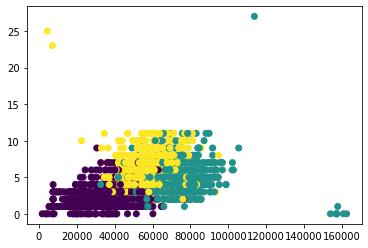

In [61]:
plottingRes = cluster.toPandas()

plt.scatter(plottingRes["Income"], plottingRes["NumWebPurchases"], c=plottingRes["prediction"])
plt.show()

In [ ]:
# GATAU LAH KONTOOOOOOOOOOL